In [129]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
import xgboost as xgb
import matplotlib.pyplot as plt

In [130]:
# Load and preprocess the dataset
df = pd.read_csv('SP500_with_indicators_^GSPC.csv').dropna()
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Create lagged features
def create_lagged_features(data, columns, lag=30):
    """
    Generate lagged features for time series prediction for specified columns.
    """
    lagged_columns = {}  # Use a dictionary to collect all lagged columns
    for col in columns:
        for i in range(1, lag + 1):
            lagged_columns[f'{col}_Lag_{i}'] = data[col].shift(i)

    # Combine the original DataFrame with lagged columns
    lagged_df = pd.concat([data, pd.DataFrame(lagged_columns, index=data.index)], axis=1)
    lagged_df.dropna(inplace=True)  # Drop rows with NaN values (due to lagging)
    
    return lagged_df

# Use multiple features for lagging
lagged_df = create_lagged_features(df, columns=['Adj Close', 'Volume', 'High', 'Low'], lag=30)
X = lagged_df.drop(columns=['Adj Close']).values
y = lagged_df['Adj Close'].values

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
# Time Series Cross-Validation 
tscv = TimeSeriesSplit(n_splits=5)

# Initialize XGBoost
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# Define the parameter grid
param_grid = {
    'max_depth': [6, 8, 10],
    'learning_rate': [0.05, 0.1, 0.2],
    'n_estimators': [200, 300, 500],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'reg_alpha': [0.01, 0.1],
    'reg_lambda': [0.5, 1.0]
}

# Pre-tune XGBoost hyperparameters using GridSearchCV on full training set
split_idx = int(len(X_scaled) * 0.8)
X_train_full, y_train_full = X_scaled[:split_idx], y[:split_idx]
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    max_depth=10,
    learning_rate=0.05,
    n_estimators=200,
    reg_alpha=0.01,
    reg_lambda=1.0,
    random_state=42,
)
# # Use TimeSeriesSplit for GridSearchCV
# time_series_cv = TimeSeriesSplit(n_splits=5)
# grid_search = GridSearchCV(
#     estimator=xgb_model,
#     param_grid=param_grid,
#     scoring='neg_mean_squared_error',
#     cv=time_series_cv,
#     verbose=1,
#     n_jobs=1
# )
# grid_search.fit(X_train_full, y_train_full)
# best_params = grid_search.best_params_
# print("\nBest Parameters for XGBoost:", best_params)

# Use the best hyperparameters for XGBoost in the cross-validation loop
# optimized_xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42, **best_params)
optimized_xgb_model = xgb_model.fit(X_train_full, y_train_full)

In [132]:
# Cross-validation evaluation for all models
xgb_mae = []
xgb_rmse = []
xgb_r2 = []
fold = 1

for train_idx, test_idx in tscv.split(X):
    # Train-test split
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    # Apply scaling only on training data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train the model
    optimized_xgb_model.fit(X_train_scaled, y_train)
    xgb_pred = optimized_xgb_model.predict(X_test_scaled)
    xgb_mae.append(mean_absolute_error(y_test, xgb_pred))
    xgb_rmse.append(np.sqrt(mean_squared_error(y_test, xgb_pred)))
    xgb_r2.append(r2_score(y_test, xgb_pred))

    print(f"Fold {fold}:")
    print(f"  XGBoost - MAE={xgb_mae[-1]:.2f}, RMSE={xgb_rmse[-1]:.2f}, R2={xgb_r2[-1]:.4f}")
    fold += 1

# Average metrics across folds
print("\nCross-Validation Results (Average):")
print(f"XGBoost - MAE: {np.mean(xgb_mae):.2f}, RMSE: {np.mean(xgb_rmse):.2f}, R2: {np.mean(xgb_r2):.4f}")

Fold 1:
  XGBoost - MAE=8.53, RMSE=20.70, R2=0.9764
Fold 2:
  XGBoost - MAE=5.48, RMSE=11.48, R2=0.9973
Fold 3:
  XGBoost - MAE=139.51, RMSE=230.68, R2=0.3571
Fold 4:
  XGBoost - MAE=343.48, RMSE=457.24, R2=-0.9766
Fold 5:
  XGBoost - MAE=917.12, RMSE=1061.84, R2=-2.5320

Cross-Validation Results (Average):
XGBoost - MAE: 282.83, RMSE: 356.39, R2: -0.2356


In [133]:
# Final Evaluation on Test Set
# Train-test split for final evaluation
split_idx = int(len(X_scaled) * 0.8)
X_train, X_test = X_scaled[:split_idx], X_scaled[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# XGBoost
optimized_xgb_model.fit(X_train, y_train)
xgb_pred = optimized_xgb_model.predict(X_test)

In [134]:
# Final evaluation metrics
xgb_mae = mean_absolute_error(y_test, xgb_pred)
xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_pred))
xgb_r2 = r2_score(y_test, xgb_pred)

# 1% Error Check
xgb_accuracy = [abs((pred - actual) / actual) <= 0.01 for pred, actual in zip(xgb_pred, y_test)]
xgb_accuracy_rate = sum(xgb_accuracy) / len(xgb_accuracy) * 100

# Print final evaluation metrics
print("\nFinal Evaluation on Test Set:")
print(f"XGBoost - Accuracy (within 1% error): {xgb_accuracy_rate:.2f}%")
print(f"XGBoost - MAE: {xgb_mae:.2f}, RMSE: {xgb_rmse:.2f}, R2: {xgb_r2:.4f}")


Final Evaluation on Test Set:
XGBoost - Accuracy (within 1% error): 14.75%
XGBoost - MAE: 837.42, RMSE: 1039.40, R2: -1.4884


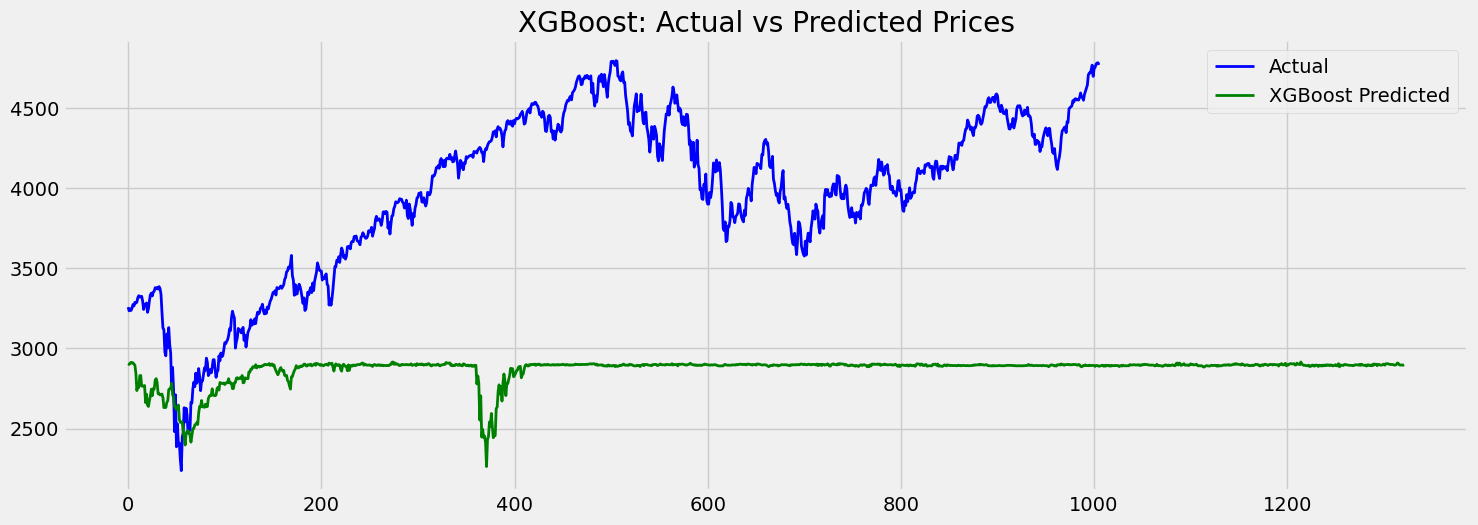

In [153]:
# Visualization
plt.figure(figsize=(15, 20))

# XGBoost: Actual vs Predicted
plt.subplot(4, 1, 2)
plt.plot(range(len(y_test)), y_test, label='Actual', color='blue', linewidth=2)
plt.plot(range(len(xgb_pred)), xgb_pred, label='XGBoost Predicted', color='green', linewidth=2)
plt.title(f'XGBoost: Actual vs Predicted Prices')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)
Test score:  0.9999320951388813
CV mean score:  0.8647834013699578
MSE:  75.58942850569757
RMSE:  37.794714252848784


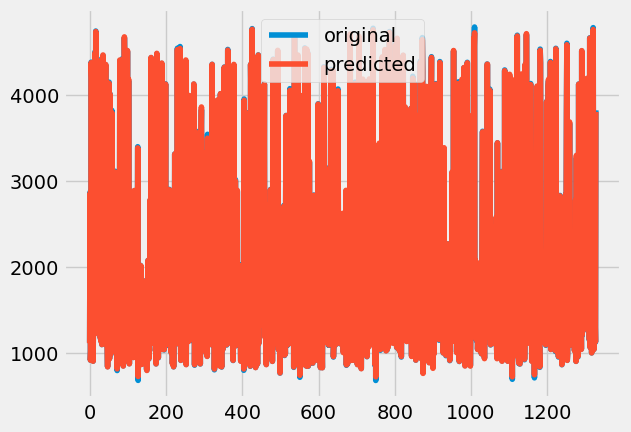

In [136]:
from sklearn.model_selection import train_test_split, cross_val_score

df = pd.read_csv('SP500_with_indicators_^GSPC.csv').dropna()
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

x, y = df.drop(columns=['Adj Close']), df['Adj Close']
x_train, xtest, y_train, ytest = train_test_split(x, y, test_size=0.2, random_state=42)

xgbr = xgb.XGBRegressor(verbosity=0, max_depth=3, learning_rate=0.1, n_estimators=100, objective='reg:squarederror')
print(xgbr)

xgbr.fit(x_train, y_train)
score = xgbr.score(xtest, ytest)
print("Test score: ", score)

cv_score = cross_val_score(xgbr, x, y, cv=10)
print("CV mean score: ", cv_score.mean())

ypred = xgbr.predict(xtest)
mse = mean_squared_error(ytest, ypred)
print("MSE: ", mse)
print("RMSE: ", mse*(1/2.0))

x_ax = range(len(ytest))
plt.plot(x_ax, ytest, label="original")
plt.plot(x_ax, ypred, label="predicted")
plt.legend()
plt.show()

In [137]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [138]:
df = pd.read_csv('SP500_with_indicators_^GSPC.csv')
df = df.set_index('Date')
#Drop MACD_Signal, Max_Drawdown, ATR, ADX, RSI, MACD, Volume, Volatility 
df = df.drop(['MACD_Signal', 'Max_Drawdown', 'ATR', 'ADX', 'RSI', 'MACD', 'Volume', 'Volatility'], axis=1)
df.index = pd.to_datetime(df.index)

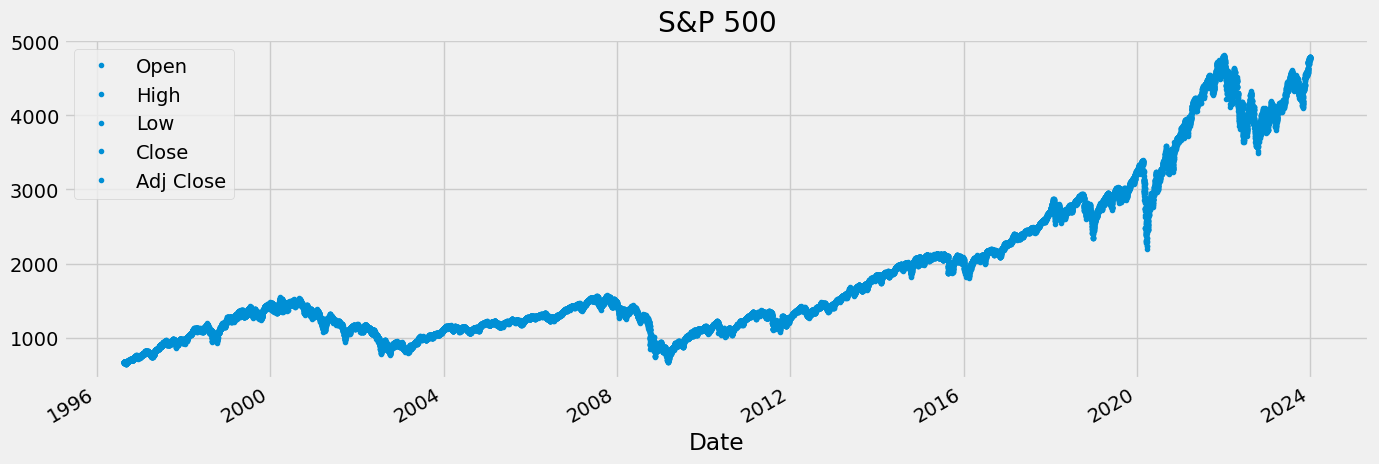

In [139]:
df.plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='S&P 500')
plt.show()

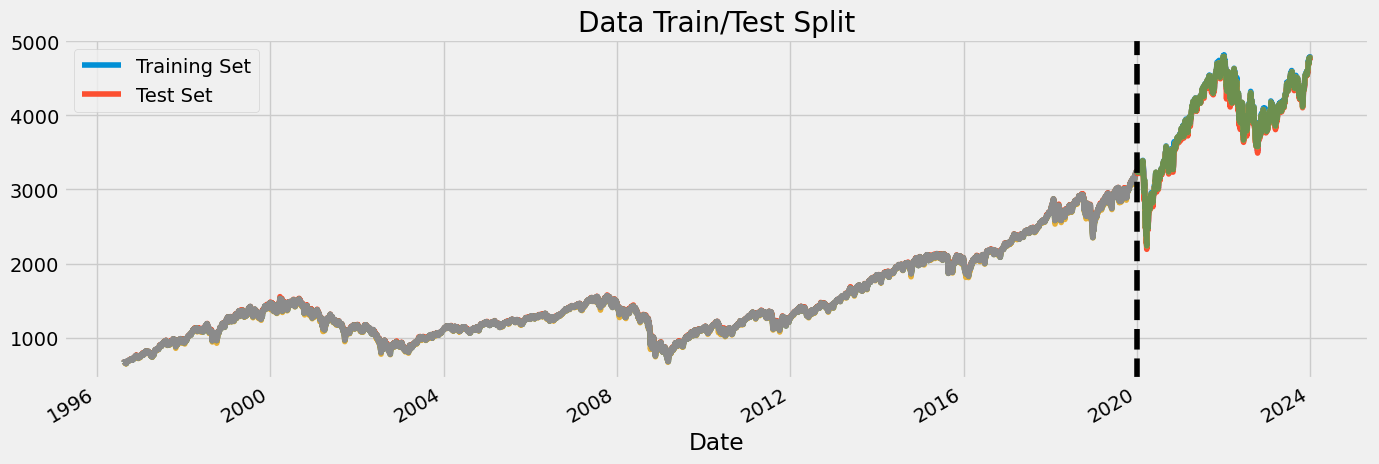

In [140]:
train = df.loc[df.index < '01-01-2020']
test = df.loc[df.index >= '01-01-2020']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2020', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

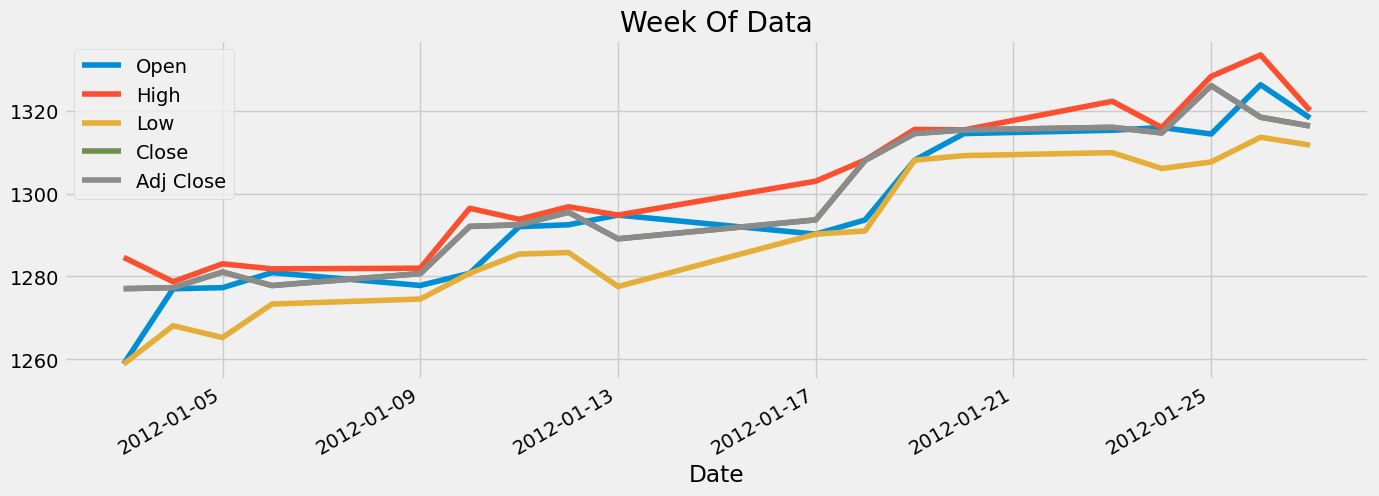

In [141]:
df.loc[(df.index > '01-01-2012') & (df.index < '01-30-2012')] \
    .plot(figsize=(15, 5), title='Week Of Data')
plt.show()

In [142]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['Date'] = df.index.date
    return df

df = create_features(df)

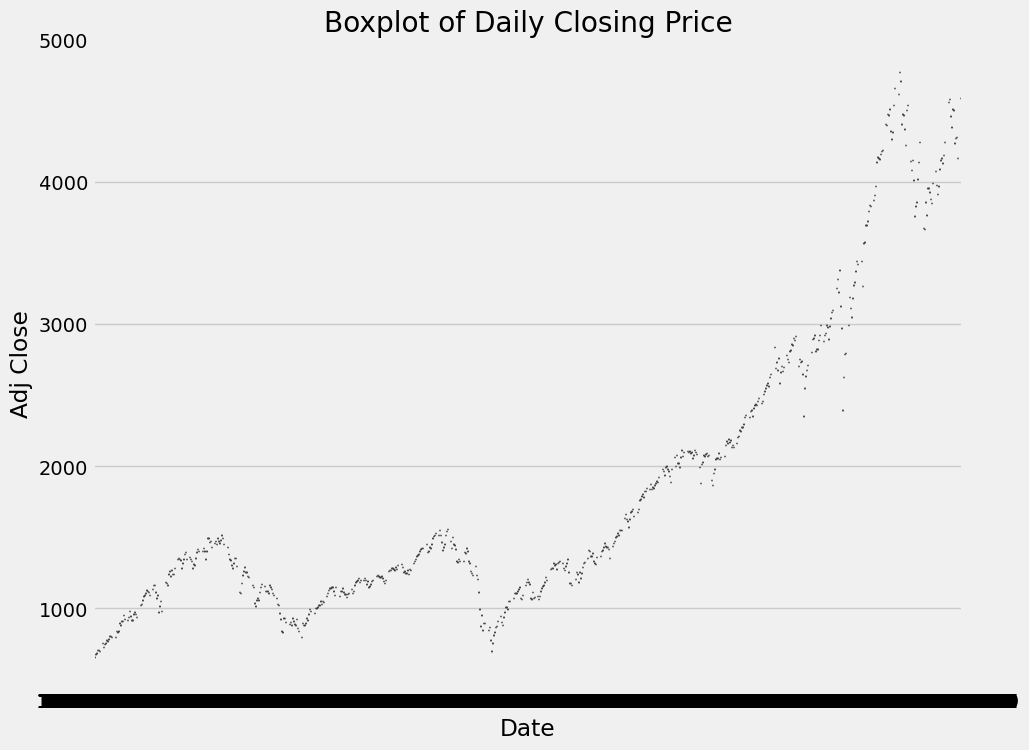

In [143]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='Date', y='Adj Close', ax=ax)
ax.set_title('Boxplot of Daily Closing Price')
plt.show()

In [144]:
train = create_features(train)
test = create_features(test)

#Date,Open,High,Low,Close,Adj Close,Volume,ATR,ADX,RSI,MACD,MACD_Signal,Volatility,Max_Drawdown
FEATURES = ['Open', 'High', 'Low', 'Close']
TARGET = 'Adj Close'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [145]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01,
                       min_samples_split=100,)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[0]	validation_0-rmse:1590.40376	validation_1-rmse:3972.33069
[100]	validation_0-rmse:585.16339	validation_1-rmse:2156.58475
[200]	validation_0-rmse:215.65121	validation_1-rmse:1434.85605


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:19:15] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:19:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "min_samples_split" } are not used.

  warnings.warn(smsg, UserWarning)


[300]	validation_0-rmse:79.72668	validation_1-rmse:1140.11737
[400]	validation_0-rmse:29.80153	validation_1-rmse:1019.86719
[500]	validation_0-rmse:11.83789	validation_1-rmse:971.26285
[600]	validation_0-rmse:6.11379	validation_1-rmse:951.85315
[700]	validation_0-rmse:4.81593	validation_1-rmse:944.20372
[800]	validation_0-rmse:4.60372	validation_1-rmse:941.35266
[900]	validation_0-rmse:4.56147	validation_1-rmse:940.31531
[999]	validation_0-rmse:4.54433	validation_1-rmse:939.71249


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, min_samples_split=100, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1000,
             n_jobs=None, num_parallel_tree=None, ...)

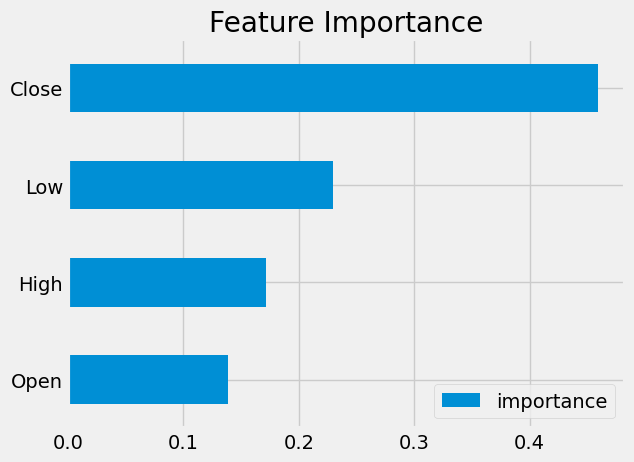

In [146]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

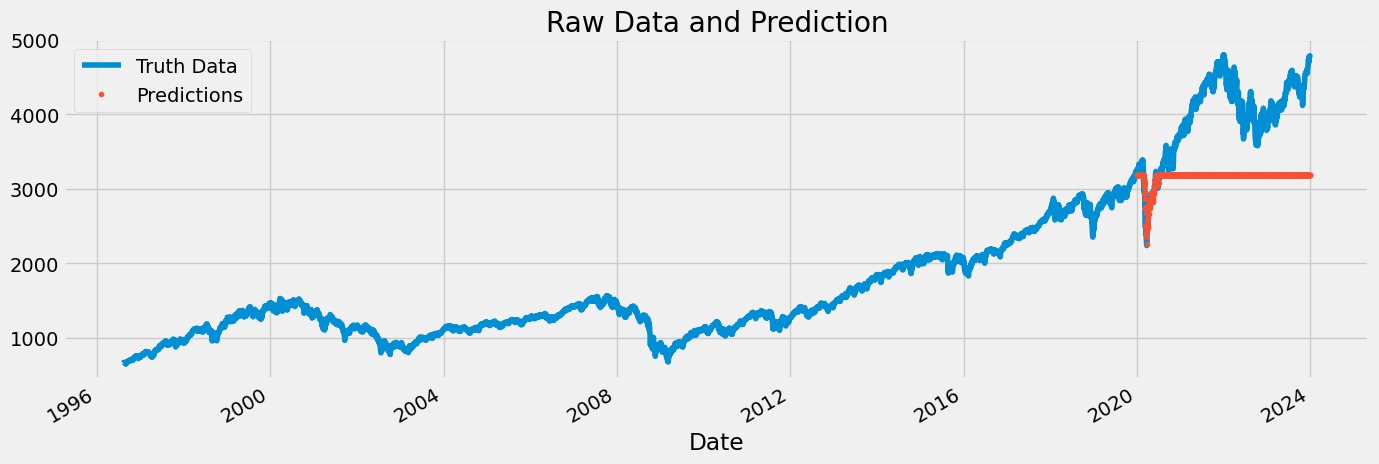

In [147]:
test['prediction'] = reg.predict(X_test)
if 'prediction' in df.columns:
    df = df.drop(columns=['prediction'])

df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)

# Plot
ax = df[['Adj Close']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data and Prediction')
plt.show()

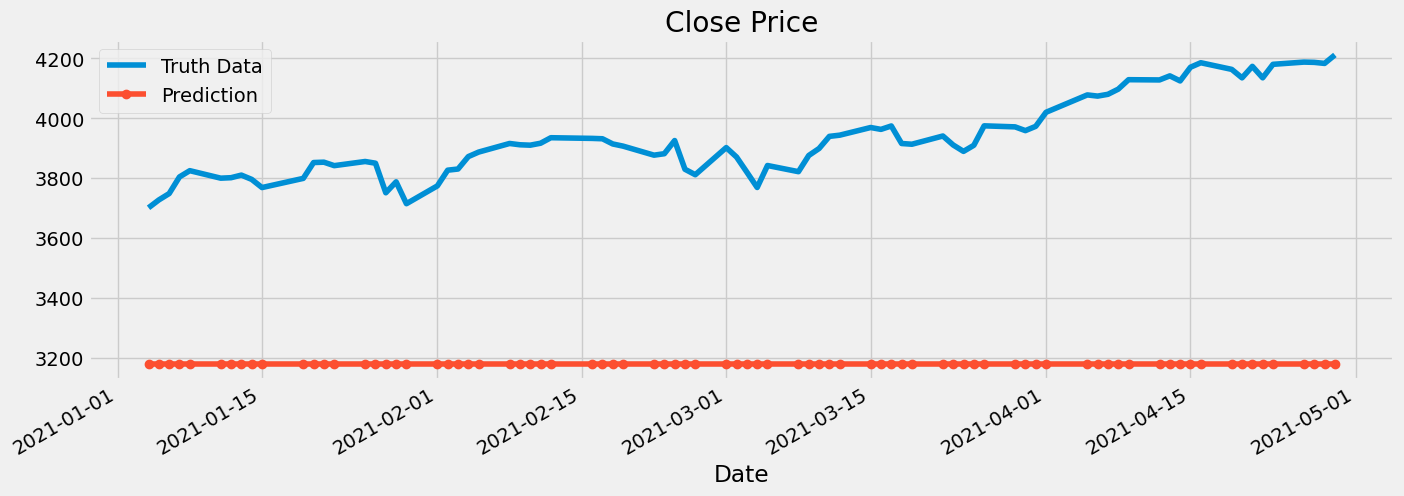

In [148]:
ax = df.loc[(df.index > '01-01-2021') & (df.index < '04-30-2021')]['Adj Close'] \
    .plot(figsize=(15, 5), title='Close Price')
df.loc[(df.index > '01-01-2021') & (df.index < '04-30-2021')]['prediction'] \
    .plot(style='-o', ax=ax)
plt.legend(['Truth Data','Prediction'])
plt.show()

In [149]:
score = np.sqrt(mean_squared_error(test['Adj Close'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 939.71


In [150]:
test['error'] = np.abs(test[TARGET] - test['prediction'])
test['date'] = test.index.date
test.groupby(['date'])['error'].mean().sort_values(ascending=True).head(20)

date
2020-04-29    0.005615
2020-05-15    0.311523
2020-04-16    0.568604
2020-04-21    0.591064
2020-05-27    1.053711
2020-04-14    1.292480
2020-07-06    1.433350
2020-03-18    1.480469
2020-04-09    1.687500
2020-03-11    1.760986
2020-05-06    1.856689
2020-04-01    1.927002
2020-05-01    1.993652
2020-05-04    2.541504
2020-05-05    2.884277
2020-06-02    3.204346
2020-04-23    3.299072
2020-04-15    3.523193
2020-05-26    4.344727
2020-03-04    5.132080
Name: error, dtype: float64